# <center> Предсказание победителя в Dota 2

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [125]:
PATH_TO_DATA = "./bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")

df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [150]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [10]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [12]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 20.3 s, sys: 209 ms, total: 20.5 s
Wall time: 2.99 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [13]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [14]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [15]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [16]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [17]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-25_18-07-20.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [19]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 3.44 s, sys: 579 ms, total: 4.02 s
Wall time: 19.4 s


In [20]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [21]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [78]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

<font size=3 color='blue'><b> Изучим содержимое json подробнее и отметим идеи<br></b></font>

In [40]:
print(f'We have {len(match["players"])} players')
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

We have 10 players


(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

In [50]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [47]:
match["players"][0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

In [122]:
match["players"][0]['lh']

85

In [94]:
player = match["players"][8]
player['ability_uses']

{'faceless_void_time_walk': 64,
 'faceless_void_chronosphere': 5,
 'faceless_void_time_dilation': 7}

Информация о количестве использованных способностей:

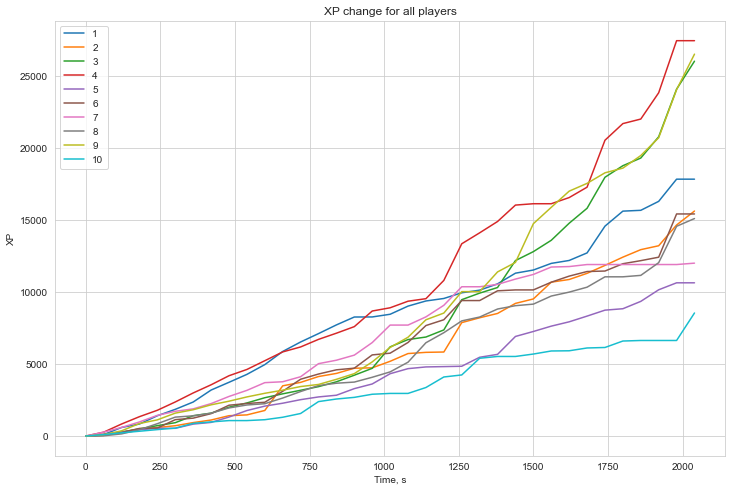

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

<font size=3 color='blue'><b> Идеи для фичей<br></b></font>  
**Из поля match['plsyers'] можно извлечь:**
- Отношение health к max_health для всей команды и понять у какой команды больше доля здовровья. Или посчитать абсолютную разницу в здоровье между командами
- Аналогично можно посчитать разницу между командами в max_mana
- Разница kills между командами
- Также можно посчитать для целевой команды суммарный "damage_taken", "damage" и сколько раз членов команды убивали "killed_by"
- Посчитать сколько раз в команде использовали все айтемы "item_uses"
- разницу в xp между командами
- и другие. Вытянем по максимуму
  
**Дополнительные категориальные признаки, которые можно закодировать one_hot энкодингом:**  
- "game_mode"
- "lobby_type". Вполне возможно сетап тоже влияет на успех команды
- "hero_id" - можно сделатть набор фичей, соответствующих персонажам в доте и ставить единички в соответствующих полях если такой персонаж есть в команде radiant

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [266]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
#def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
def read_matches(matches_file, total_matches=7977, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

<font size=3 color='blue'><b> Работу по улучшению модели начнем из этой точки на стадии добавления новых фичей<br></b></font>

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [137]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    hero_id_set = set() # a set to collect al heroes from input data
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем свои признаки
        
        # MORE GENERAL FEATURES
        
        # the number of team fights
        df_features.loc[match_id_hash, "n_fights"] = len(match['teamfights'])
        
        # categorial features
        df_features.loc[match_id_hash, "game_mode"] = match['game_mode']
        df_features.loc[match_id_hash, "lobby_type"] = match['lobby_type']
        
        
        # PLAYER_RELATED FEATURES
        
        kda_radiant, kda_dire = [], []
        health_radiant, health_dire = 0, 0
        max_health_radiant, max_health_dire = 0, 0
        mana_radiant, mana_dire = 0, 0
        kills_radiant, kills_dire = 0, 0
        damage_taken_radinat, damage_taken_dire = 0, 0
        item_uses_radiant, item_uses_dire = 0, 0
        ability_uses_radiant, ability_uses_dire = 0, 0
        xp_radiant, xp_dire = [], []
        hero_ids_radiant, hero_ids_dire = [], []
        
        ability_upgrades_radiant, ability_upgrades_dire = [], []
        first_blood_radiant = 0
        obs_radiant, obs_dire = 0, 0
        sen_radiant, sen_dire = 0, 0
        creeps_radiant, creeps_dire = 0, 0
        rune_radiant, rune_dire = 0, 0
        camp_radiant, camp_dire = 0, 0
        stuns_radiant, stuns_dire = 0, 0
        teamfight_radiant, teamfight_dire = [], []
        max_hit_radiant, max_hit_dire = [], []
        purchase_radiant, purchase_dire = 0, 0
        multi_kills_radiant, multi_kills_dire = 0, 0
        healing_radiant, healing_dire = [], []
        gold_radiant, gold_dire = [], []
        lh_radiant, lh_dire = [], []
        level_radiant, level_dire = [], []
        creep_death_radiant, creep_death_dire = [], []

        for player in match["players"]:
            hero_id_set.add(player['hero_id'])
            
            if player['player_slot'] < 10: # add features to radiant
                if player["deaths"] > 0:
                    kda_radiant.append((player["kills"] + player["assists"]) / player["deaths"])
                else:
                    kda_radiant.append(player["kills"] + player["assists"] + 1)
                health_radiant += player['health']
                max_health_radiant += player['max_health']
                mana_radiant += player['max_mana']
                kills_radiant += player['kills']
                damage_taken_radinat += sum(player['damage_taken'].values())
                item_uses_radiant += sum(player['item_uses'].values())
                ability_uses_radiant +=  sum(player['ability_uses'].values())
                xp_radiant.append(player['xp'])
                hero_ids_radiant.append(player['hero_id'])
                ability_upgrades_radiant.append(len(player['ability_upgrades']))
                obs_radiant += player['obs_placed']
                sen_radiant += player['sen_placed']
                creeps_radiant += player['creeps_stacked']
                camp_radiant += player['camps_stacked']
                rune_radiant += player['rune_pickups']
                stuns_radiant += player['stuns']
                teamfight_radiant.append(player['teamfight_participation'])
                max_hit_radiant.append(player['max_hero_hit']['value'])
                purchase_radiant += len(player['purchase_log'])
                multi_kills_radiant += len(player['multi_kills'])
                healing_radiant.append(sum([h for h in player['healing'].values()]))
                gold_radiant.append(player['gold'])
                lh_radiant.append(player['lh'])
                level_radiant.append(player['level'])
                creep_death_radiant.append(player['nearby_creep_death_count'])
                if player['firstblood_claimed'] > 0:
                    first_blood_radiant = 1
                    
            else: # add features to dire
                
                if player["deaths"] > 0:
                    kda_dire.append((player["kills"] + player["assists"]) / player["deaths"])
                else:
                    kda_dire.append(player["kills"] + player["assists"] + 1)
                health_dire += player['health']
                max_health_dire += player['max_health']
                mana_dire += player['max_mana']
                kills_dire += player['kills']
                damage_taken_dire += sum(player['damage_taken'].values())
                item_uses_dire += sum(player['item_uses'].values())
                ability_uses_dire +=  sum(player['ability_uses'].values())
                xp_dire.append(player['xp'])
                hero_ids_dire.append(player['hero_id'])
                ability_upgrades_dire.append(len(player['ability_upgrades']))
                obs_dire += player['obs_placed']
                sen_dire += player['sen_placed']
                creeps_dire += player['creeps_stacked']
                camp_dire += player['camps_stacked']
                rune_dire += player['rune_pickups']
                stuns_dire += player['stuns']
                teamfight_dire.append(player['teamfight_participation'])
                max_hit_dire.append(player['max_hero_hit']['value'])
                purchase_dire += len(player['purchase_log'])
                multi_kills_dire += len(player['multi_kills'])
                healing_dire.append(sum([h for h in player['healing'].values()]))
                gold_dire.append(player['gold'])
                lh_dire.append(player['lh'])
                level_dire.append(player['level'])
                creep_death_dire.append(player['nearby_creep_death_count'])

        # kda features
        df_features.loc[match_id_hash, "radiant_kda"] = np.array(kda_radiant).mean()
        df_features.loc[match_id_hash, "dire_kda"] = np.array(kda_dire).mean()       
        df_features.loc[match_id_hash, "diff_kda"] = np.array(kda_radiant).mean() - np.array(kda_dire).mean()

        # health features
        df_features.loc[match_id_hash, "radiant_health"] = health_radiant
        df_features.loc[match_id_hash, "dire_health"] = health_dire 
        df_features.loc[match_id_hash, "diff_health"] = health_radiant - health_dire
        df_features.loc[match_id_hash, "radiant_max_health"] = max_health_radiant
        df_features.loc[match_id_hash, "dire_max_health"] = max_health_dire
        df_features.loc[match_id_hash, "diff_max_health"] = max_health_radiant - max_health_dire

        df_features.loc[match_id_hash, "radiant_health_ratio"] = health_radiant / max_health_radiant
        df_features.loc[match_id_hash, "dire_health_ratio"] = health_dire / max_health_dire
        df_features.loc[match_id_hash, "diff_health_ratio"] = (health_radiant / max_health_radiant) - (health_dire / max_health_dire)

        # max_mana features
        df_features.loc[match_id_hash, "radiant_mana"] = mana_radiant
        df_features.loc[match_id_hash, "dire_mana"] = mana_dire 
        df_features.loc[match_id_hash, "diff_mana"] = mana_radiant - mana_dire

        # kills features
        df_features.loc[match_id_hash, "radiant_kills"] = kills_radiant
        df_features.loc[match_id_hash, "dire_kills"] = kills_dire 
        df_features.loc[match_id_hash, "diff_kills"] = kills_radiant - kills_dire

        # damage_taken
        df_features.loc[match_id_hash, "radiant_damage_taken"] = damage_taken_radinat
        df_features.loc[match_id_hash, "dire_damage_taken"] = damage_taken_dire
        df_features.loc[match_id_hash, "diff_damage_taken"] = damage_taken_radinat - damage_taken_dire

        # item_uses
        df_features.loc[match_id_hash, "radiant_item_uses"] = item_uses_radiant
        df_features.loc[match_id_hash, "dire_item_uses"] = item_uses_dire
        df_features.loc[match_id_hash, "diff_item_uses"] = item_uses_radiant - item_uses_dire

        # ability_uses
        df_features.loc[match_id_hash, "radiant_ability_uses"] = ability_uses_radiant
        df_features.loc[match_id_hash, "dire_ability_uses"] = ability_uses_dire
        df_features.loc[match_id_hash, "diff_ability_uses"] = ability_uses_radiant - ability_uses_dire

        # xp features
        df_features.loc[match_id_hash, "radiant_xp_total"] = sum(xp_radiant)
        df_features.loc[match_id_hash, "radiant_xp_mean"] = np.array(xp_radiant).mean()
        df_features.loc[match_id_hash, "dire_xp_total"] = sum(xp_dire)
        df_features.loc[match_id_hash, "dire_xp_mean"] = np.array(xp_dire).mean()
        df_features.loc[match_id_hash, "diff_xp_total"] = sum(xp_radiant) - sum(xp_dire)
        df_features.loc[match_id_hash, "diff_xp_mean"] = np.array(xp_radiant).mean() - np.array(xp_dire).mean()
        
        # heroes in teams
        df_features.loc[match_id_hash, "radiant_heroes"] = '_'.join([str(i) for i in hero_ids_radiant])
        df_features.loc[match_id_hash, "dire_heroes"] = '_'.join([str(i) for i in hero_ids_dire])
        
        # total obs placed in teams
        df_features.loc[match_id_hash, "radiant_obs"] = obs_radiant
        df_features.loc[match_id_hash, "dire_obs"] = obs_dire
        df_features.loc[match_id_hash, "diff_obs"] = obs_radiant - obs_dire
        
        # total sen placed in teams
        df_features.loc[match_id_hash, "radiant_sen"] = sen_radiant
        df_features.loc[match_id_hash, "dire_sen"] = sen_dire
        df_features.loc[match_id_hash, "diff_sen"] = sen_radiant - sen_dire
        
        # total creeps stacked in teams
        df_features.loc[match_id_hash, "radiant_creeps"] = creeps_radiant
        df_features.loc[match_id_hash, "dire_creeps"] = creeps_dire
        df_features.loc[match_id_hash, "diff_creeps"] = creeps_radiant - creeps_dire
        
        # total camps in teams
        df_features.loc[match_id_hash, "radiant_camps"] = camp_radiant
        df_features.loc[match_id_hash, "dire_camps"] = camp_dire
        df_features.loc[match_id_hash, "diff_camps"] = camp_radiant - camp_dire
        
        # total rune pickups in teams
        df_features.loc[match_id_hash, "radiant_rune"] = rune_radiant
        df_features.loc[match_id_hash, "dire_rune"] = rune_dire
        df_features.loc[match_id_hash, "diff_rune"] = rune_radiant - rune_dire
        
        # total and mean ability upgrades in teams
        df_features.loc[match_id_hash, "radiant_ability_up"] = sum(ability_upgrades_radiant)
        df_features.loc[match_id_hash, "dire_ability_up"] = sum(ability_upgrades_dire)
        df_features.loc[match_id_hash, "diff_ability_up"] = sum(ability_upgrades_radiant) - sum(ability_upgrades_dire)
        df_features.loc[match_id_hash, "radiant_ability_up_mean"] = np.array(ability_upgrades_radiant).mean()
        df_features.loc[match_id_hash, "dire_ability_up_mean"] = np.array(ability_upgrades_dire).mean()
        df_features.loc[match_id_hash, "diff_ability_up_mean"] = np.array(ability_upgrades_radiant).mean() - np.array(ability_upgrades_dire).mean()
        
        # total stuns in teams
        df_features.loc[match_id_hash, "radiant_stuns"] = stuns_radiant
        df_features.loc[match_id_hash, "dire_stuns"] = stuns_dire
        df_features.loc[match_id_hash, "diff_stuns"] = stuns_radiant - stuns_dire
        
        # average teamfight participation
        df_features.loc[match_id_hash, "radiant_ability_up"] = np.array(teamfight_radiant).mean()
        df_features.loc[match_id_hash, "dire_ability_up"] = np.array(teamfight_dire).mean()
        df_features.loc[match_id_hash, "diff_ability_up"] = np.array(teamfight_radiant).mean() - np.array(teamfight_dire).mean()
        
        # average max hit
        df_features.loc[match_id_hash, "radiant_max_hit"] = np.array(max_hit_radiant).mean()
        df_features.loc[match_id_hash, "dire_max_hit"] = np.array(max_hit_dire).mean()
        df_features.loc[match_id_hash, "diff_max_hit"] = np.array(max_hit_radiant).mean() - np.array(max_hit_dire).mean()
        
        # total purchase in teams
        df_features.loc[match_id_hash, "radiant_purchase"] = purchase_radiant
        df_features.loc[match_id_hash, "dire_purchase"] = purchase_dire
        df_features.loc[match_id_hash, "diff_purchase"] = purchase_radiant - purchase_dire
        
        # total multi-kills in teams
        df_features.loc[match_id_hash, "radiant_multi_kills"] = multi_kills_radiant
        df_features.loc[match_id_hash, "dire_multi_kills"] = multi_kills_dire
        df_features.loc[match_id_hash, "diff_multi_kills"] = multi_kills_radiant - multi_kills_dire
        
        # total and mean healing in teams
        df_features.loc[match_id_hash, "radiant_heal"] = sum(healing_radiant)
        df_features.loc[match_id_hash, "dire_heal"] = sum(healing_dire)
        df_features.loc[match_id_hash, "diff_heal"] = sum(healing_radiant) - sum(healing_dire)
        df_features.loc[match_id_hash, "radiant_heal_mean"] = np.array(healing_radiant).mean()
        df_features.loc[match_id_hash, "dire_heal_mean"] = np.array(healing_dire).mean()
        df_features.loc[match_id_hash, "diff_heal_mean"] = np.array(healing_radiant).mean() - np.array(healing_dire).mean()
        
        # total and mean gold in teams
        df_features.loc[match_id_hash, "radiant_gold"] = sum(gold_radiant)
        df_features.loc[match_id_hash, "dire_gold"] = sum(gold_dire)
        df_features.loc[match_id_hash, "diff_gold"] = sum(gold_radiant) - sum(gold_dire)
        df_features.loc[match_id_hash, "radiant_gold_mean"] = np.array(gold_radiant).mean()
        df_features.loc[match_id_hash, "dire_gold_mean"] = np.array(gold_dire).mean()
        df_features.loc[match_id_hash, "diff_gold_mean"] = np.array(gold_radiant).mean() - np.array(gold_dire).mean()
        
        # total and mean lh in teams
        df_features.loc[match_id_hash, "radiant_lh"] = sum(lh_radiant)
        df_features.loc[match_id_hash, "dire_lh"] = sum(lh_dire)
        df_features.loc[match_id_hash, "diff_lh"] = sum(lh_radiant) - sum(lh_dire)
        df_features.loc[match_id_hash, "radiant_lh_mean"] = np.array(lh_radiant).mean()
        df_features.loc[match_id_hash, "dire_lh_mean"] = np.array(lh_dire).mean()
        df_features.loc[match_id_hash, "diff_lh_mean"] = np.array(lh_radiant).mean() - np.array(lh_dire).mean()
        
        # total and mean level in teams
        df_features.loc[match_id_hash, "radiant_level"] = sum(level_radiant)
        df_features.loc[match_id_hash, "radiant_level_mean"] = np.array(level_radiant).mean()
        df_features.loc[match_id_hash, "dire_level"] = sum(level_dire)
        df_features.loc[match_id_hash, "dire_level_mean"] = np.array(level_dire).mean()
        df_features.loc[match_id_hash, "diff_level"] = sum(level_radiant) - sum(level_dire)
        df_features.loc[match_id_hash, "diff_level_mean"] = np.array(level_radiant).mean() - np.array(level_dire).mean()
        
        # total and mean creap deaths in teams
        df_features.loc[match_id_hash, "radiant_creep_death"] = sum(creep_death_radiant)
        df_features.loc[match_id_hash, "radiant_creep_death_mean"] = np.array(creep_death_radiant).mean()
        df_features.loc[match_id_hash, "dire_creep_death"] = sum(creep_death_dire)
        df_features.loc[match_id_hash, "dire_creep_death_mean"] = np.array(creep_death_dire).mean()
        df_features.loc[match_id_hash, "diff_creep_death"] = sum(creep_death_radiant) - sum(creep_death_dire)
        df_features.loc[match_id_hash, "diff_creep_death_mean"] = np.array(creep_death_radiant).mean() - np.array(creep_death_dire).mean()
        
        # whether first blood is claimed by radiant
        df_features.loc[match_id_hash, "first_bloof_radiant"] = first_blood_radiant
        
    return hero_id_set

In [138]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
hero_id_set = add_new_features(df_train_features_extended, 
                               os.path.join(PATH_TO_DATA, "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [140]:
len(hero_id_set)

115

In [141]:
# check for Na in dataset
df_train_features_extended[df_train_features_extended.isna().any(axis=1)]

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,dire_level_mean,diff_level,diff_level_mean,radiant_creep_death,radiant_creep_death_mean,dire_creep_death,dire_creep_death_mean,diff_creep_death,diff_creep_death_mean,first_bloof_radiant
match_id_hash,,,,,,,,,,,,,,,,,,,,,


In [142]:
# save intermediate data
#df_train_features_extended.to_csv(f'{PATH_TO_DATA}/train_features_extended_2_intermediate.csv')

In [148]:
# reload intermediate data 
df_train_features_extended = pd.read_csv(f'{PATH_TO_DATA}/train_features_extended_2_intermediate.csv',
                                         index_col="match_id_hash")
df_train_features_extended.shape

(31698, 348)

In [149]:
# let's transform 'game_mode' and 'lobby_type' using onehot encoding
from sklearn.preprocessing import OneHotEncoder

print(f'Initial shape {df_train_features_extended.shape}')
enc1, enc2 = OneHotEncoder(), OneHotEncoder()
data_lobby_mode = df_train_features_extended[['game_mode', 'lobby_type']]

modes = pd.DataFrame(enc1.fit_transform(data_lobby_mode[['game_mode']]).toarray(),
                     columns=[f'mode_{i}' for i in range(8)])

lobby = pd.DataFrame(enc2.fit_transform(data_lobby_mode[['lobby_type']]).toarray(),
                    columns=[f'lobby_{i}' for i in range(2)])

df_train_features_extended = pd.concat([df_train_features_extended,
                                        modes.set_index(df_train_features_extended.index)], axis=1)

df_train_features_extended = pd.concat([df_train_features_extended,
                                        lobby.set_index(df_train_features_extended.index)], axis=1)

print(f'Final shape {df_train_features_extended.shape}')
df_train_features_extended

Initial shape (31698, 348)
Final shape (31698, 358)


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,lobby_0,lobby_1
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [158]:
# encoding of heroes in teams
print(f'There are {len(hero_id_set)} heroes')
print(f'Initial shape {df_train_features_extended.shape}')

#list of heroes
hero_ids = [str(h) for h in hero_id_set]

# encode radiant teams
radiant_teams = np.zeros((df_train_features_extended.shape[0], len(hero_ids)))
for i, combination in enumerate(df_train_features_extended.radiant_heroes):
    heroes = combination.split('_')
    for hero in heroes:
        radiant_teams[i, hero_ids.index(hero)] += 1
        
radiant_teams = pd.DataFrame(data=radiant_teams,
                             columns=[f'radiant_hero_{i}' for i in hero_ids])
        
# encode dire teams
dire_teams = np.zeros((df_train_features_extended.shape[0], len(hero_ids)))
for i, combination in enumerate(df_train_features_extended.dire_heroes):
    heroes = combination.split('_')
    for hero in heroes:
        dire_teams[i, hero_ids.index(hero)] += 1
        
dire_teams = pd.DataFrame(data=dire_teams,
                             columns=[f'dire_hero_{i}' for i in hero_ids])
        
# add encoded features to the dataframe
df_train_features_extended = pd.concat([df_train_features_extended,
                                        radiant_teams.set_index(df_train_features_extended.index),
                                        dire_teams.set_index(df_train_features_extended.index)],
                                        axis=1)

print(f'Final shape {df_train_features_extended.shape}')

There are 115 heroes
Initial shape (31698, 358)
Final shape (31698, 588)


In [159]:
# save encoded data
# df_train_features_extended.to_csv(f'{PATH_TO_DATA}/train_features_extended_2_encoded.csv')

## reload encoded data

In [160]:
df_train_features_extended = pd.read_csv(f'{PATH_TO_DATA}/train_features_extended_2_encoded.csv',
                                         index_col='match_id_hash')

In [161]:
# для дальнейшей работы удалим категориальные признаки, оставив их кодировку
print(df_train_features_extended.shape)
df_train_features_extended = df_train_features_extended.drop(['lobby_type', 'game_mode', 'radiant_heroes', 'dire_heroes'],
                                                             axis=1)
print(df_train_features_extended.shape)

(31698, 588)
(31698, 584)


<font size=3 color='blue'><b> Попробуем пенерести фичу game_time в признаки для обучения. Возможно, если команда делает резкие успехи за небольшое время это сильно повышает шанс на победу. Или к примеру неудачи за небольшой промежуток времени не так критичны как неудачи в течение нескольких десятков минут.<br></b></font>  
  
<font size=3 color='blue'><b> Оказалось, она уже была там. Ну и хорошо)<br></b></font>

## PCA + применение модели на данных с пониженной размерностью

<font size=3 color='blue'><b> Попробуем сделать PCA на наших данных, может понижение размерности положительно скажется на работе модели<br></b></font>

In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [163]:
x = df_train_features_extended.values
scaler = StandardScaler().fit(x)
x = scaler.transform(x) #rescaled data
# y is already defined

n_comp = 10
pca = PCA(n_components = n_comp)
pca.fit(x)

principalComponents = pca.transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                           columns = ['principal component %d' % i for i in range(1, n_comp + 1)])

scores_df = pd.concat([principal_df,
                       df_train_targets["radiant_win"].reset_index(drop=True)],
                       axis = 1)

scores_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,radiant_win
0,-7.516092,4.597115,-1.151822,1.449740,-1.534978,-0.711321,0.244049,-1.088995,0.406909,0.581412,True
1,-15.102468,0.126177,-3.134209,1.191843,-0.124539,-2.592520,0.596732,1.321133,-0.108391,-0.028252,True
2,-14.330173,0.796379,-0.323618,0.532658,-0.181193,0.290382,1.800479,2.485649,-0.126764,0.155528,False
3,-4.331091,0.550075,-0.971460,0.212348,-0.911061,-1.067778,-0.900839,0.184786,-0.849893,0.339105,True
4,-8.141101,-1.037554,2.441550,-3.612446,0.967361,-0.015921,0.406293,-1.529513,1.085180,0.610369,False


[20.42357486 23.70839486 24.76628673 25.69353908 26.43569987 27.11938077
 27.73939346 28.35281946 28.9264509  29.49743727]


Text(0, 0.5, 'cumulative explained variance')

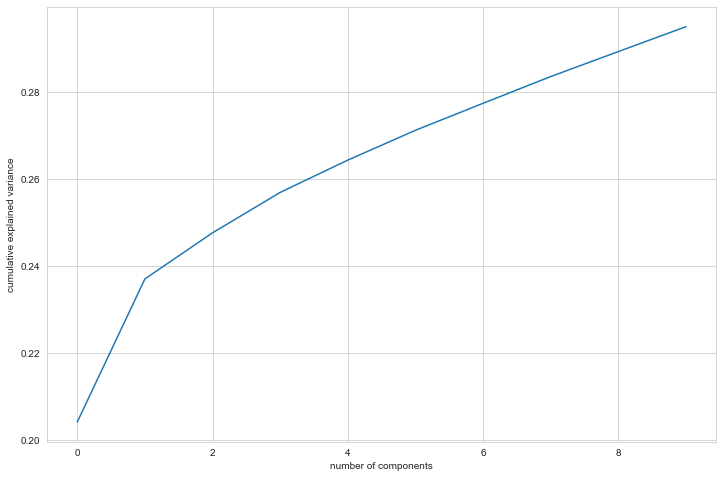

In [164]:
# plot explained variance

print(np.cumsum(pca.explained_variance_ratio_ )* 100)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

<Figure size 1080x1080 with 0 Axes>

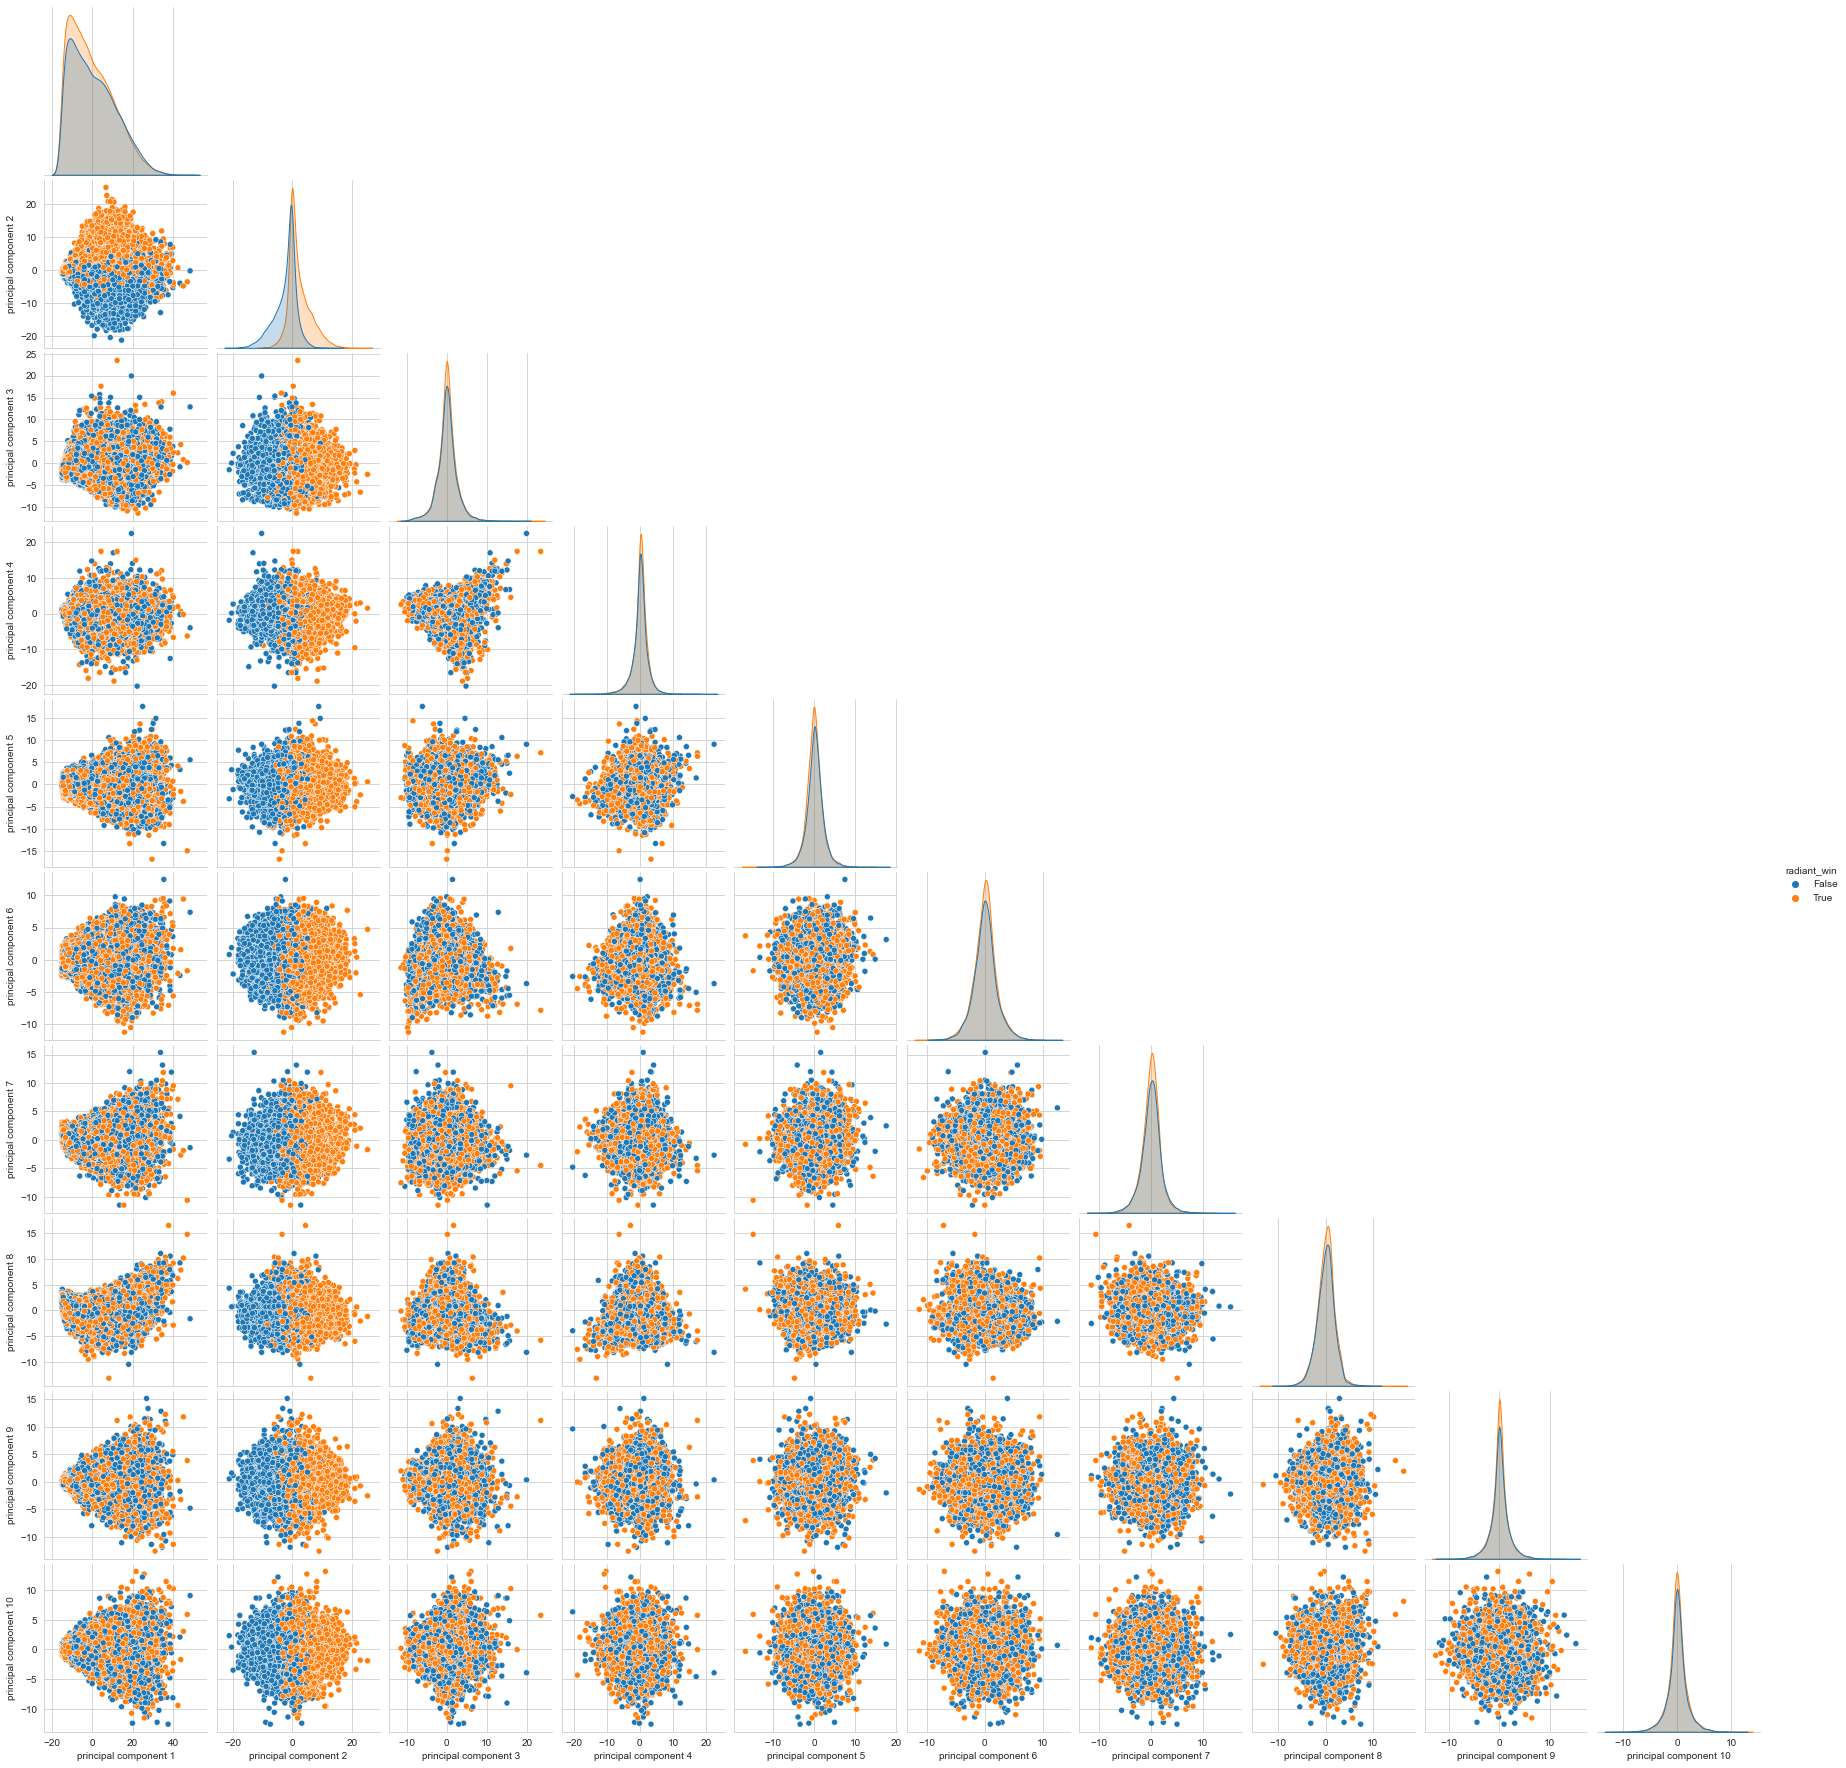

In [166]:
plt.figure(figsize=(15, 15))
sns.pairplot(data=scores_df, hue='radiant_win', corner=True)

<font size=3 color='blue'><b> Видно некоторое разделение точек в осях главных компонент. Первые 10 комонент объясняют лишь 29% variance. Но все же попробуем использовать значения главных компонент для построения модели.<br></b></font> 
  
<font size=3 color='blue'><b>Попробуем применить логистическую регрессию:<br></b></font>

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [168]:
X = principal_df.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [169]:
# initiate model 
lr_to_optimize = LogisticRegression(solver='saga', max_iter=10000, n_jobs=4, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

grid_search = GridSearchCV(lr_to_optimize,
                            param_grid={"penalty": ['l1', 'l2', 'elasticnet', 'none']}, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X, y))

# запускаем поиск
grid_search.fit(X, y)
print(grid_search.best_params_)
print(f'Best score: {grid_search.best_score_}')

{'penalty': 'l2'}
Best score: 0.8069120137226304


<font size=3 color='blue'><b> Для этого вариaнта скор уже лучше базовой модели<br></b></font>
   
<font size=3 color='blue'><b> Попробуем обучить дерево на данных:<br></b></font>

In [170]:
from sklearn.tree import DecisionTreeClassifier

In [171]:
# initiate model 
tr_to_optimize = DecisionTreeClassifier(random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

grid = {"criterion": ['gini', 'entropy'],
        "max_depth": [6, 7, 8, 9, 10, 11, 12],
        "min_samples_split": [5, 10, 20, 30, 50],
        "min_samples_leaf": [10, 20, 30, 40]}


grid_search = GridSearchCV(tr_to_optimize,
                            param_grid=grid, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X, y))

# запускаем поиск
grid_search.fit(X, y)
print(grid_search.best_params_)
print(f'Best score: {grid_search.best_score_}')

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 5}
Best score: 0.8031227740066571


<font size=3 color='blue'><b> Дерево чуточку лучше логиcтической регрессии<br></b></font>
  
<font size=3 color='blue'><b> Применим GaussianNB:<br></b></font>

In [172]:
from sklearn.naive_bayes import GaussianNB

In [173]:
# initiate model 
gnb_model = GaussianNB()

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
gnb_cv_scores = cross_val_score(gnb_model, X, y, cv=shuf_spl, scoring="roc_auc", n_jobs=-1)

print(f'Mean score: {gnb_cv_scores.mean()}')

Mean score: 0.7986127781600818


<font size=3 color='blue'><b> Модель стала похуже, но не сильно<br></b></font>
 
<font size=3 color='blue'><b> KNN<br></b></font>

In [187]:
from sklearn.neighbors import KNeighborsClassifier

In [185]:
knn_to_optimize = KNeighborsClassifier()

shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
grid_search = GridSearchCV(knn_to_optimize,
                            param_grid={
                                'weights' : ['uniform', 'distance'],
                                'n_neighbors' : [41, 61, 71, 81]
                            }, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X, y))

# запускаем поиск
grid_search.fit(X, y)
print(grid_search.best_params_)
print(f'Best score: {grid_search.best_score_}')

{'n_neighbors': 81, 'weights': 'uniform'}
Best score: 0.8013855740295124


<font size=3 color='blue'><b> Тоже неплохо, но видимо есть склонность к переобучению<br></b></font>

<font size=3 color='blue'><b> Применим варианты SVC:<br></b></font>

In [174]:
from sklearn.svm import SVC

In [175]:
svc = SVC(kernel='linear', probability=True, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
svc_cv_scores = cross_val_score(svc, X, y, cv=shuf_spl, scoring="roc_auc", n_jobs=-1)

print(f'Mean score: {svc_cv_scores.mean()}')

Mean score: 0.8041162696527475


In [176]:
svc = SVC(kernel='rbf', probability=True, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
svc_cv_scores = cross_val_score(svc, X, y, cv=shuf_spl, scoring="roc_auc", n_jobs=-1)

print(f'Mean score: {svc_cv_scores.mean()}')

Mean score: 0.8004064191147748


<font size=3 color='blue'><b> SVC показали себя неплохо но работают они очень долго<br></b></font>
  
<font size=3 color='blue'><b> Оптимизируем случайный лес:<br></b></font>

In [177]:
from sklearn.model_selection import RandomizedSearchCV

In [178]:
# модель для оптимизации
rf_model_to_iptimize = RandomForestClassifier(n_jobs=4, random_state=SEED)

# гиперпараметры для оптимизации
params = {"n_estimators"      : [100, 300, 500, 700] ,
          "max_depth"         : [4, 7, 9, 11, 13, 16],
          "min_samples_split" : [8, 14, 20, 26],
          "min_samples_leaf"  : [5, 10, 20]}

param_comb = 90 # parameter combinations to sample

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

random_search = RandomizedSearchCV(rf_model_to_iptimize,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   n_jobs=4,
                                   cv=shuf_spl.split(X, y),
                                   random_state=SEED)

# запускаем поиск
random_search.fit(X, y)
print(random_search.best_params_)
print(f'Best score: {random_search.best_score_}')

{'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 11}
Best score: 0.8076342934680438


<font size=3 color='blue'><b> Скор на уровне логистической регрессиии и дерева решений<br></b></font>

<font size=3 color='blue'><b> Ансамбль моделей:<br></b></font>

In [223]:
from sklearn.ensemble import VotingClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=6,
                            min_samples_leaf=20, min_samples_split=5, random_state=SEED)

rf = RandomForestClassifier(n_estimators=500, min_samples_split=20,
                            min_samples_leaf=20, max_depth=11, random_state=SEED, n_jobs=-1)

knn = KNeighborsClassifier(n_neighbors=71, weights="uniform")

svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)

lr = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=SEED, penalty='l2')
nb = GaussianNB()

In [220]:
# изменил функцию, чтобы возвращать результаты в виде матрицы
from scipy.stats import pearsonr
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    
    base_model_names = [str(est) for est in ensemble.named_estimators_.keys()]
    corrs = np.zeros((len(base_model_names), len(base_model_names)))
    
    estimators = ensemble.named_estimators_
    
    for (i, est1_name), (j, est2_name) in combinations(enumerate(base_model_names), 2):
        Xi_test = X
        Xj_test = X
        
        est1, est2 = estimators[est1_name], estimators[est2_name]
        
        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        
        corrs[base_model_names.index(est2_name), 
              base_model_names.index(est1_name)] = pearsonr(ypred_t1, ypred_t2)[0]
    
    return base_model_names, corrs

In [215]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CV-score: 0.8116027361278985


<AxesSubplot:>

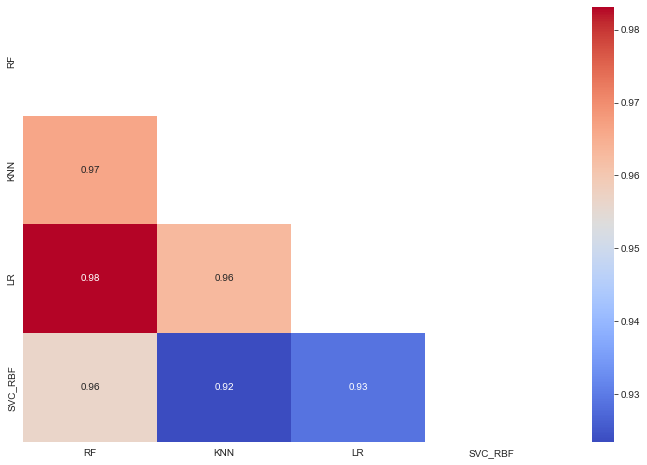

In [230]:
base_models = [("RF", rf),  ("KNN", knn), ("LR", lr),
               ("SVC_RBF", svc_rbf)]

# soft voting
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)

shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
score = cross_val_score(voting_soft, X_train, y_train, cv=shuf_spl, scoring='roc_auc', n_jobs=-1).mean()
print(f'CV-score: {score}')

# посмотрим на корреляцию моделей в обновленном ансамбле
model_names, corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_valid)

mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, xticklabels=model_names, yticklabels=model_names, mask=mask, annot=True, cmap="coolwarm")

## Оптимизация случайного леса на данных в полной размерности
<font size=3 color='blue'><b> Попробуем оптимизировать гиперпараметры случайного леса для данных без PCA:<br></b></font>

In [233]:
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [234]:
# модель для оптимизации
rf_model_to_iptimize = RandomForestClassifier(n_jobs=4, random_state=SEED, warm_start=False)

# гиперпараметры для оптимизации
params = {"n_estimators"      : [100, 300, 500, 700, 1000] ,
          "max_depth"         : [4, 7, 9, 11, 13, 16],
          "min_samples_split" : [8, 14, 20, 26],
          "min_samples_leaf"  : [2, 5, 10, 20]}

param_comb = 90 # parameter combinations to sample

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

random_search = RandomizedSearchCV(rf_model_to_iptimize,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   n_jobs=4,
                                   cv=shuf_spl.split(X, y),
                                   random_state=SEED)

# запускаем поиск
random_search.fit(X, y)
print(random_search.best_params_)
print(f'Best score: {random_search.best_score_}')

{'n_estimators': 700, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 13}
Best score: 0.8168470242649647


<font size=3 color='blue'><b> Модель стала лучше<br></b></font>  
  
<font size=3 color='blue'><b> Попробуем объединить основной датафрейм с главными компонентами и оптимизировать случайный лес на этих данных:<br></b></font>

In [241]:
combined_df = pd.concat([df_train_features_extended,
                         principal_df.set_index(df_train_features_extended.index)],
                         axis=1)

X_ext = combined_df.values

In [256]:
# модель для оптимизации
rf_model_to_iptimize = RandomForestClassifier(n_jobs=-1, random_state=SEED, warm_start=False)

# гиперпараметры для оптимизации
params = {"n_estimators"      : [100, 300, 500, 700, 1000] ,
          "max_depth"         : [4, 7, 9, 11, 13, 16],
          "min_samples_split" : [8, 14, 20, 26],
          "min_samples_leaf"  : [2, 5, 10, 20]}

param_comb = 90 # parameter combinations to sample

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

random_search = RandomizedSearchCV(rf_model_to_iptimize,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=shuf_spl.split(X_ext, y),
                                   random_state=SEED)

# запускаем поиск
random_search.fit(X_ext, y)
print(random_search.best_params_)
print(f'Best score: {random_search.best_score_}')

{'n_estimators': 700, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 16}
Best score: 0.8175299655605235


<font size=3 color='blue'><b> Модель стала лишь чуточку лучше<br></b></font>
  
<font size=3 color='blue'><b> Попробуем оптимизировать дерево решений само по себе<br></b></font>

In [258]:
# initiate model 
tr_to_optimize = DecisionTreeClassifier(random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

grid = {"criterion": ['gini', 'entropy'],
        "max_depth": [7, 10, 13, 17, 25, 32],
        "min_samples_split": [5, 10, 20, 30, 50],
        "min_samples_leaf": [10, 20, 30, 40]}


grid_search = GridSearchCV(tr_to_optimize,
                            param_grid=grid, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X_ext, y))

# запускаем поиск
grid_search.fit(X_ext, y)
print(grid_search.best_params_)
print(f'Best score: {grid_search.best_score_}')

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 40, 'min_samples_split': 5}
Best score: 0.8020644413941284


<font size=3 color='blue'><b> Результат заметно уступает лесу<br></b></font>
  
<font size=3 color='blue'><b> Стандартизируем данные в основном датафрейме (с добавлением PCA и без них) и опробуем другие модели. Для начала логистическая регрессия:<br></b></font>

In [253]:
# стандартизация
scaler = StandardScaler().fit(df_train_features_extended)
X_scaled = scaler.transform(df_train_features_extended)

# Х с добавлением главных компонент и без них
X_scaled_pca =  np.concatenate([X_scaled, principal_df.values], axis=1)

In [255]:
# initiate model 
lr_to_optimize = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

grid_search_1 = GridSearchCV(lr_to_optimize,
                            param_grid={"penalty": ['l1', 'l2', 'elasticnet', 'none']}, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X_scaled, y))

grid_search_2 = GridSearchCV(lr_to_optimize,
                            param_grid={"penalty": ['l1', 'l2', 'elasticnet', 'none']}, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X_scaled_pca, y))

# запускаем поиск
grid_search_1.fit(X_scaled, y)
grid_search_2.fit(X_scaled_pca, y)

print(f'Best score without PCA features: {grid_search_1.best_score_}')
print(grid_search_1.best_params_)

print(f'Best score with PCA features: {grid_search_2.best_score_}')
print(grid_search_2.best_params_)

Best score without PCA features: 0.8285430043110841
{'penalty': 'l1'}
Best score with PCA features: 0.8285451241369627
{'penalty': 'l1'}


<font size=3 color='blue'><b> Пока что это лйчший результат!<br></b></font>

<font size=3 color='blue'><b> Попробуем также GaussianNB:<br></b></font>

In [259]:
# initiate model 
gnb_model = GaussianNB()

# задаем параметры для k-fold и рандомизированного поиска
shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

gnb_cv_scores_1 = cross_val_score(gnb_model, X_scaled, y, cv=shuf_spl, scoring="roc_auc", n_jobs=-1)
gnb_cv_scores_2 = cross_val_score(gnb_model, X_scaled_pca, y, cv=shuf_spl, scoring="roc_auc", n_jobs=-1)

print(f'Mean score on scaled data: {gnb_cv_scores_1.mean()}')
print(f'Mean score on scaked data with PCs: {gnb_cv_scores_2.mean()}')

Mean score on scaled data: 0.7779942793845286
Mean score on scaked data with PCs: 0.7798682753966746


<font size=3 color='blue'><b> Результат заметно хуже<br></b></font>

<font size=3 color='blue'><b> KNN:<br></b></font>

In [260]:
knn_to_optimize = KNeighborsClassifier()

shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

# задаем параметры для k-fold и рандомизированного поиска
grid_search1 = GridSearchCV(knn_to_optimize,
                            param_grid={
                                'weights' : ['uniform', 'distance'],
                                'n_neighbors' : [41, 61, 71, 81]
                            }, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X_scaled, y))

grid_search2 = GridSearchCV(knn_to_optimize,
                            param_grid={
                                'weights' : ['uniform', 'distance'],
                                'n_neighbors' : [41, 61, 71, 81]
                            }, 
                            scoring='roc_auc',
                            n_jobs=4, 
                            cv=shuf_spl.split(X_scaled_pca, y))

# запускаем поиск
grid_search1.fit(X_scaled, y)
grid_search2.fit(X_scaled_pca, y)

print(f'Best score on scaled data: {grid_search1.best_score_}')
print(grid_search1.best_params_)

print(f'Best score on scaled data with PCs: {grid_search2.best_score_}')
print(grid_search2.best_params_)

Best score on scaled data: 0.7883058616259742
{'n_neighbors': 81, 'weights': 'distance'}
Best score on scaled data with PCs: 0.7970326168118412
{'n_neighbors': 81, 'weights': 'distance'}


<font size=3 color='blue'><b> Тоже не очень<br></b></font>
  
<font size=3 color='blue'><b> Попробуем составить ансамбль моделей и применить его к данным после стандартизации и с добавлением PCs<br></b></font>

## Ансамбль моделей на стандартизированных данных с добавлением PC

In [263]:
rf = RandomForestClassifier(n_estimators=700, min_samples_split=20,
                            min_samples_leaf=10, max_depth=16, random_state=SEED)

knn = KNeighborsClassifier(n_neighbors=81, weights="distance")

svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)

lr = LogisticRegression(solver='saga', max_iter=10000, n_jobs=4, random_state=SEED, penalty='l1')

In [264]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled_pca, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CV-score: 0.8355640351824221


<AxesSubplot:>

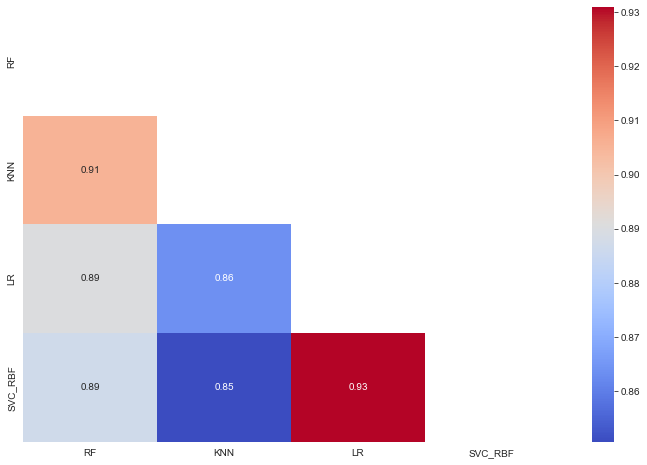

In [265]:
base_models = [("RF", rf),  ("KNN", knn), ("LR", lr),
               ("SVC_RBF", svc_rbf)]

# soft voting
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)

shuf_spl = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
score = cross_val_score(voting_soft, X_train, y_train, cv=shuf_spl, scoring='roc_auc', n_jobs=-1).mean()
print(f'CV-score: {score}')

# посмотрим на корреляцию моделей в обновленном ансамбле
model_names, corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_valid)

mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, xticklabels=model_names, yticklabels=model_names, mask=mask, annot=True, cmap="coolwarm")

<font size=3 color='blue'><b> Эту модель и зафиксируем!<br></b></font>

<font size=3 color='blue'><b> ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513<br></b></font>
<font size=3 color='blue'><b> ROC-AUC для улучшенной модели составил: 0.8355640351824221<br></b></font>

<font size=3 color='blue'><b> Сохраним лучший результат, опроовав модель на тестовых данных:<br></b></font>

In [267]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

df_test_features_extended = df_test_features.copy()

# add features from json
not_needed_ids = add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, "test_raw_data.jsonl"))

print(f'Final shape {df_test_features_extended.shape}')

  0%|          | 0/7977 [00:00<?, ?it/s]

Final shape (7977, 348)


In [268]:
# one hot encoding
data_lobby_mode = df_test_features_extended[['game_mode', 'lobby_type']]

modes = pd.DataFrame(enc1.transform(data_lobby_mode[['game_mode']]).toarray(),
                     columns=[f'mode_{i}' for i in range(8)])

lobby= pd.DataFrame(enc2.transform(data_lobby_mode[['lobby_type']]).toarray(),
                    columns=[f'lobby_{i}' for i in range(2)])

df_test_features_extended = pd.concat([df_test_features_extended,
                                        modes.set_index(df_test_features_extended.index)], axis=1)

df_test_features_extended = pd.concat([df_test_features_extended,
                                        lobby.set_index(df_test_features_extended.index)], axis=1)

print(f'Final shape {df_test_features_extended.shape}')

Final shape (7977, 358)


In [269]:
# encode heroes ids
#list of heroes
hero_ids = [str(h) for h in hero_id_set]

# encode radiant teams
radiant_teams = np.zeros((df_test_features_extended.shape[0], len(hero_ids)))
for i, combination in enumerate(df_test_features_extended.radiant_heroes):
    heroes = combination.split('_')
    for hero in heroes:
        radiant_teams[i, hero_ids.index(hero)] += 1
        
radiant_teams = pd.DataFrame(data=radiant_teams,
                             columns=[f'radiant_hero_{i}' for i in hero_ids])
        
# encode dire teams
dire_teams = np.zeros((df_test_features_extended.shape[0], len(hero_ids)))
for i, combination in enumerate(df_test_features_extended.dire_heroes):
    heroes = combination.split('_')
    for hero in heroes:
        dire_teams[i, hero_ids.index(hero)] += 1
        
dire_teams = pd.DataFrame(data=dire_teams,
                             columns=[f'dire_hero_{i}' for i in hero_ids])
        
# add encoded features to the dataframe
df_test_features_extended = pd.concat([df_test_features_extended,
                                        radiant_teams.set_index(df_test_features_extended.index),
                                        dire_teams.set_index(df_test_features_extended.index)],
                                        axis=1)

print(f'Final shape {df_test_features_extended.shape}')

Final shape (7977, 588)


In [271]:
# для дальнейшей работы удалим категориальные признаки, оставив их кодировку
print(df_test_features_extended.shape)
df_test_features_extended = df_test_features_extended.drop(['lobby_type', 'game_mode', 'radiant_heroes', 'dire_heroes'],
                                                             axis=1)
print(df_test_features_extended.shape)

(7977, 588)
(7977, 584)


In [272]:
# стандартизируем данные
X_test_scaled = scaler.transform(df_test_features_extended.values) #rescaled data

# добавим главные компоненты
principalComponents = pca.transform(X_test_scaled)

# объединим
X_test = np.concatenate([X_test_scaled, principalComponents], axis=1)
print(X_test.shape)

(7977, 594)


In [273]:
# запустим нашу модель
y_test_pred = voting_soft.predict_proba(X_test)[:, 1]

In [275]:
# сохраним предсказание
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features_extended.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-04_01-26-45.csv
